In [188]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [172]:
df_train = pd.read_csv('mercedes-benz-greener-manufacturing/train.csv')
df_train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [173]:
df_test = pd.read_csv('mercedes-benz-greener-manufacturing/test.csv')
df_test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [174]:
oe = preprocessing.OrdinalEncoder()

encoder = df_train.drop(['y','ID'], axis=1)
encoder1 = encoder.select_dtypes(exclude='int64')

encoder1 = oe.fit_transform(encoder1)
encoder2 = encoder.select_dtypes(include='int64')

encodedvals = np.append(encoder1,encoder2,axis=1)

encodedframe = pd.DataFrame(encodedvals.astype('int'))
encodedframe.head()

,0,1,2,3,4,5,6,7,8,9,...,366,367,368,369,370,371,372,373,374,375
0,32,23,17,0,3,24,9,14,0,0,...,0,0,1,0,0,0,0,0,0,0
1,32,21,19,4,3,28,11,14,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,24,34,2,3,27,9,23,0,0,...,0,0,0,0,0,0,1,0,0,0
3,20,21,34,5,3,27,11,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,20,23,34,5,3,12,3,13,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
threshold = 0.9

corr_matrix = encodedframe.corr().abs().round(2)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Select columns with Pearson's correlations above threshold
collinear_features = [column for column in upper.columns if any(upper[column] > threshold)]
features_filtered = encodedframe.drop(columns = collinear_features)
print('The number of features that passed the collinearity threshold: ', features_filtered.shape[1])
features_best = []
features_best.append(features_filtered.columns.tolist())

The number of features that passed the collinearity threshold:  280


In [330]:
pca = PCA(30) 
pcacols = pca.fit_transform(encodedvals)

In [333]:
scaler = StandardScaler()
scaler.fit(pcacols)
pcascaled = scaler.transform(pcacols)

In [331]:
pca.explained_variance_ratio_

array([3.83347821e-01, 2.13880326e-01, 1.32618659e-01, 1.18266425e-01,
       9.20600842e-02, 1.59060433e-02, 7.44539716e-03, 4.33701278e-03,
       2.94020637e-03, 2.41796178e-03, 2.36488035e-03, 2.03228597e-03,
       1.67203776e-03, 1.48111202e-03, 1.28702378e-03, 1.03575260e-03,
       9.57334243e-04, 8.96963711e-04, 7.85687496e-04, 7.09719872e-04,
       6.44381973e-04, 6.23812981e-04, 5.84619627e-04, 5.12442875e-04,
       4.84777251e-04, 4.33105367e-04, 4.13936003e-04, 3.77626124e-04,
       3.68589689e-04, 3.56040706e-04])

In [332]:
sum(pca.explained_variance_ratio_)

0.9912420665946089

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

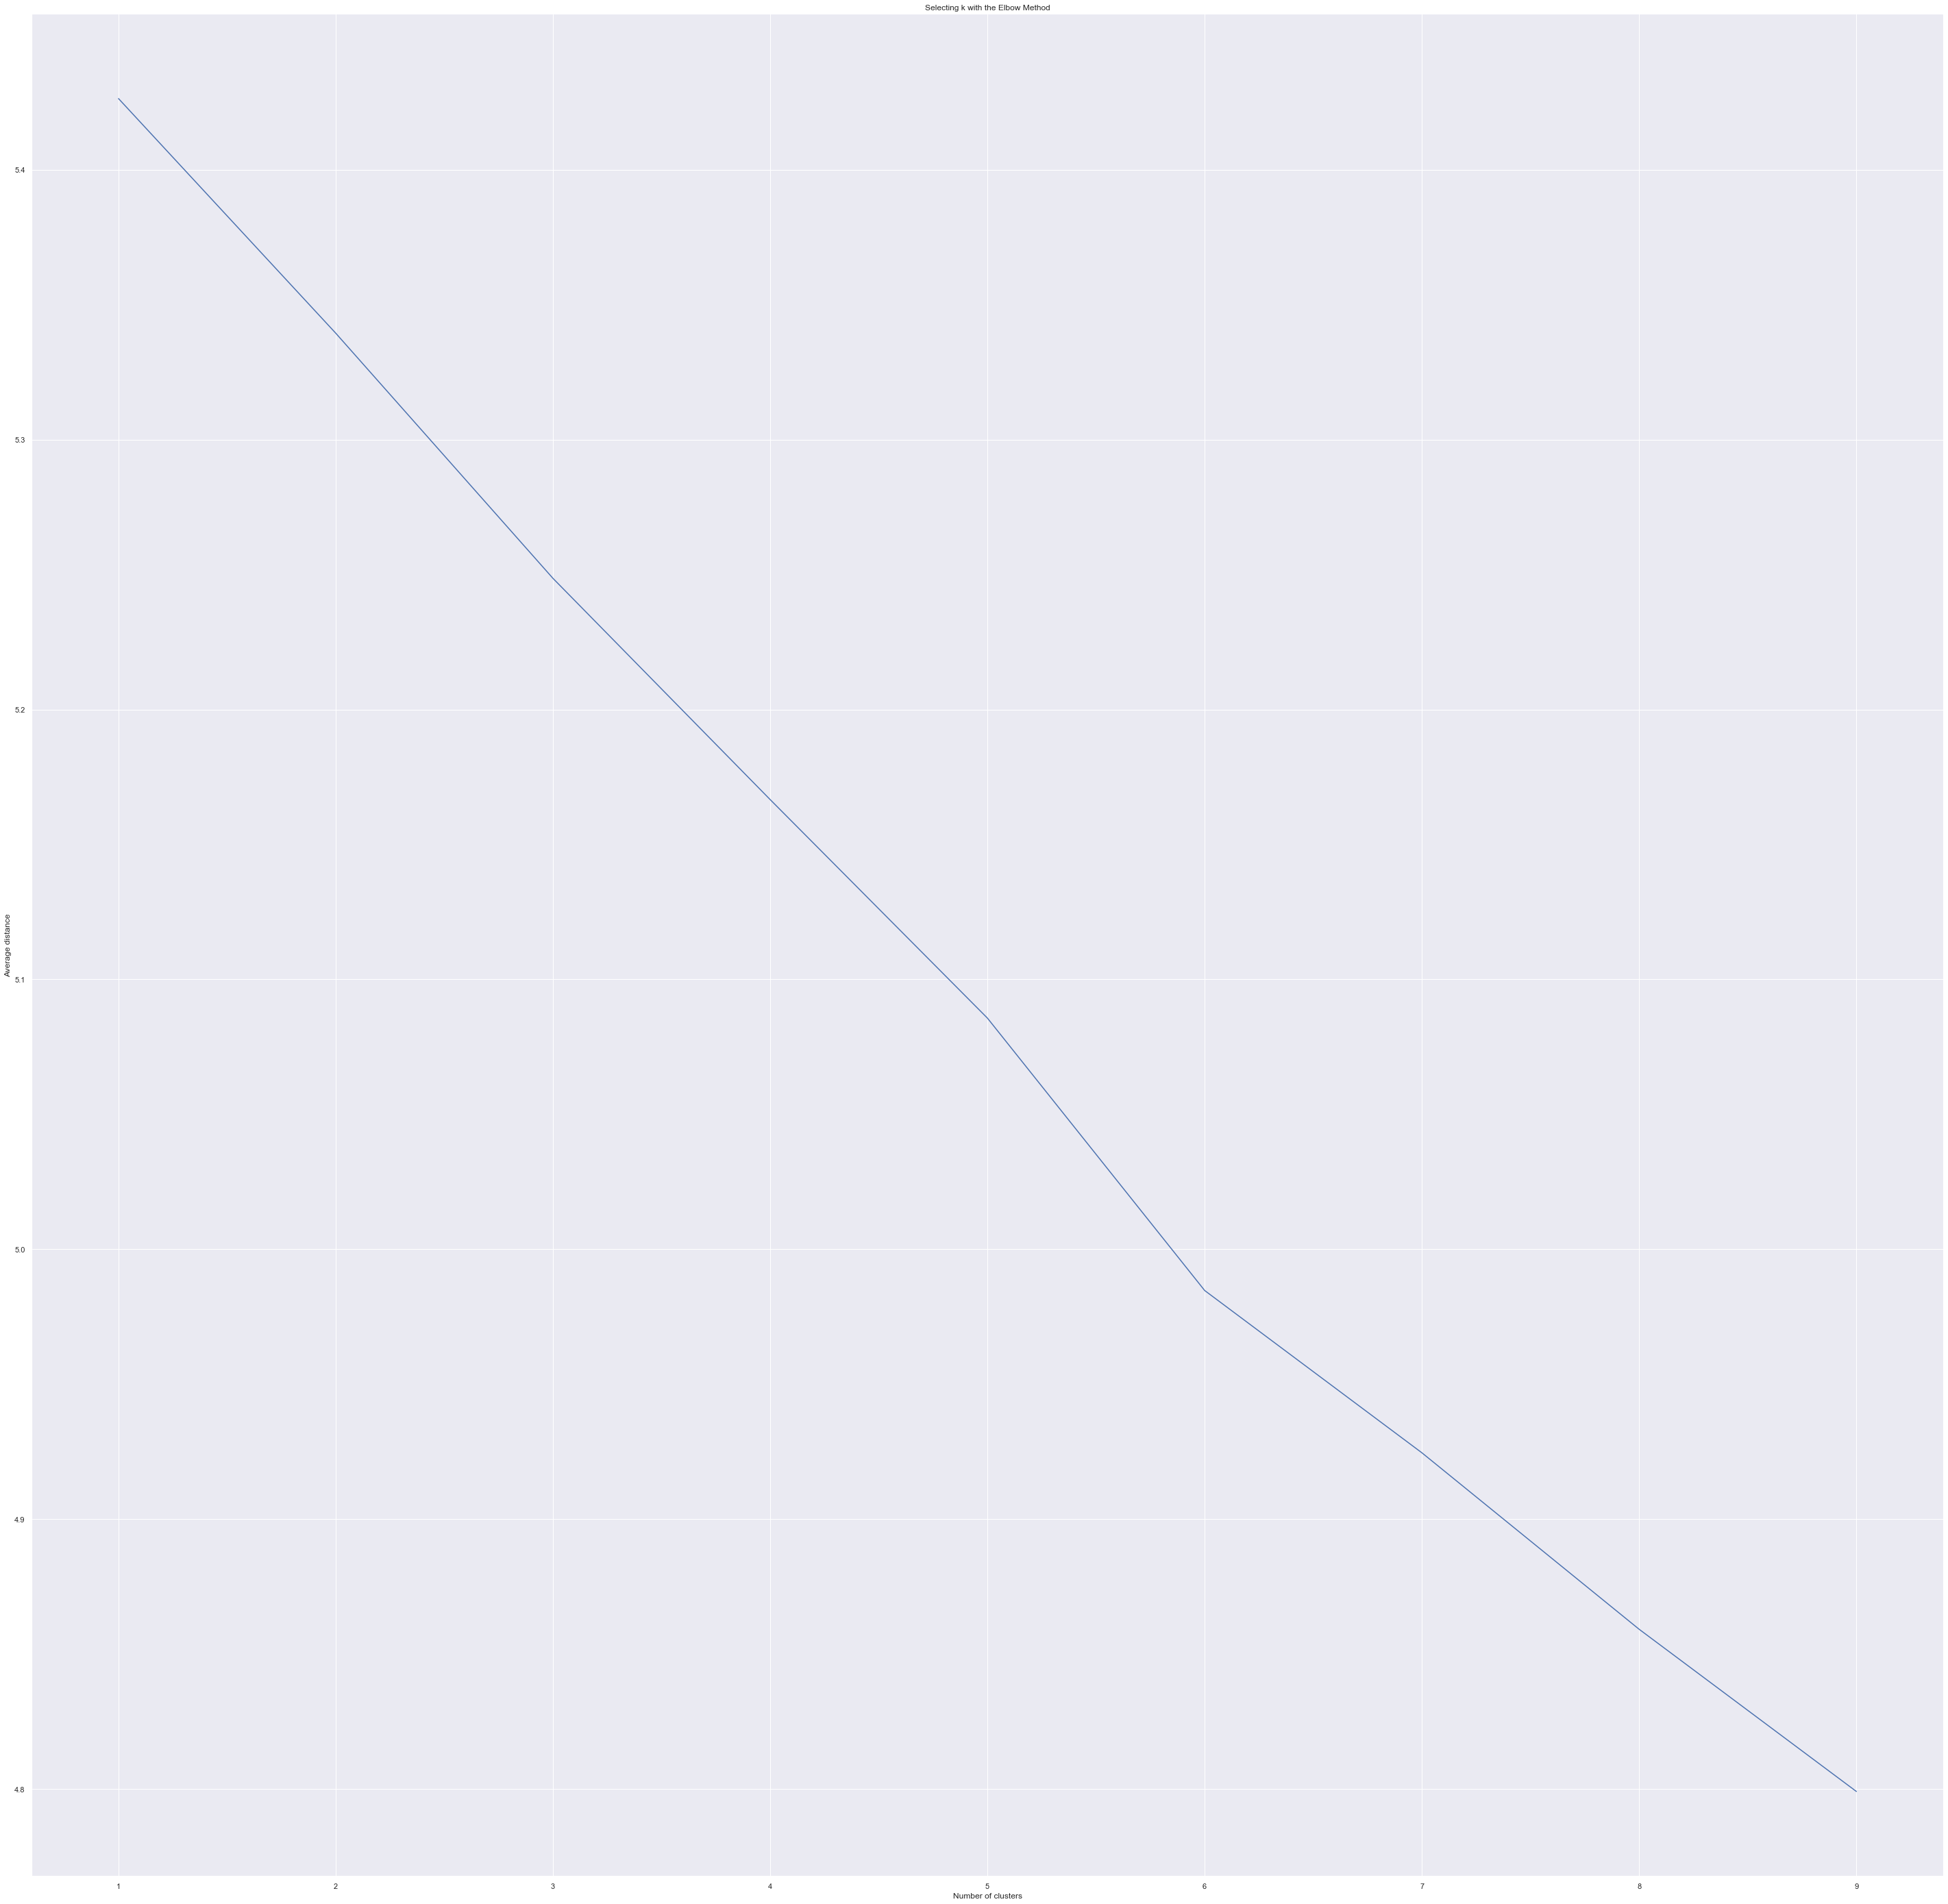

In [467]:
clusters=range(1,10)
meandist=[]

data = pcascaled
# loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean 
# distance my taking the sum divided by the shape
for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(data)
    clusassign=model.predict(data)
    meandist.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1))
    / data.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') 

In [468]:
k = KMeans(n_clusters=3, random_state=0)
kfit = k.fit(data)
kpred = kfit.predict(data)

In [469]:
pcascaleddf = pd.DataFrame(pcascaled)

In [470]:
pcascaleddf['klabel'] = pd.Series(kpred,index=encodedframe.index)
pcascaleddf['y'] = df_train['y']
pcascaleddf['ID'] = df_train['ID']

In [451]:
pcascaleddf

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,klabel,y,ID
0,0.043045,-0.012468,1.859985,0.464853,0.194256,-0.925139,1.917589,1.012230,-0.517824,1.531838,...,-2.512702,0.325435,-0.162172,2.877930,2.935668,-1.495156,-0.066528,0,130.81,0
1,0.039589,0.146264,2.132013,-0.011711,0.219556,-1.527179,-0.400194,0.534901,-0.631019,-0.120398,...,0.939978,-0.510269,-1.223005,3.055253,0.992591,-1.706123,-0.412667,0,88.53,6
2,1.134413,1.152322,2.099152,0.023486,1.693244,-0.740886,0.416096,1.040530,-0.486254,-0.427813,...,0.488212,2.702940,0.771670,0.216454,-0.452125,-0.547140,0.117861,1,76.26,7
3,1.130792,1.268800,1.773588,-0.395943,-0.976183,-1.474635,-1.118338,1.381792,0.032745,-0.863297,...,-0.173813,2.943449,-1.616408,-0.433660,0.980259,0.046328,0.066686,1,80.62,9
4,1.152435,1.235015,0.524159,0.967023,0.305751,1.293776,-0.981761,1.384796,0.942119,-0.900933,...,-0.063313,1.092657,-0.150386,0.939241,-0.374749,0.266226,-0.298902,1,78.02,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,1.551699,-0.673453,-1.030843,1.358275,0.667235,1.212672,0.923777,-0.900796,-0.795076,0.318930,...,2.422143,-1.443265,1.117505,-0.410657,1.079978,1.398678,0.311761,0,107.39,8405
4205,0.430888,2.139893,-0.989803,1.298820,-0.441395,0.025306,-0.051891,0.476005,0.706335,1.743703,...,1.015702,0.238620,0.968230,0.760061,-1.533115,0.485380,1.975455,0,108.77,8406
4206,2.030851,1.393050,-0.922981,1.414946,-0.835417,0.271313,1.708166,-0.166526,0.211515,-0.965925,...,0.171508,0.328619,-0.460554,-0.077844,-0.633771,0.319505,0.098047,0,109.22,8412
4207,1.608485,0.157934,-1.075108,1.229057,1.350152,-1.497051,-1.356285,1.131494,1.791559,0.224830,...,0.759679,-0.952914,-0.132480,0.310966,-2.263389,2.045662,0.742825,0,87.48,8415


In [471]:
label = []
for x in range(3):
    label.append(pcascaleddf.loc[pcascaleddf['klabel']==x])

In [472]:
for x in label:
    print(len(x))

1312
1341
1556


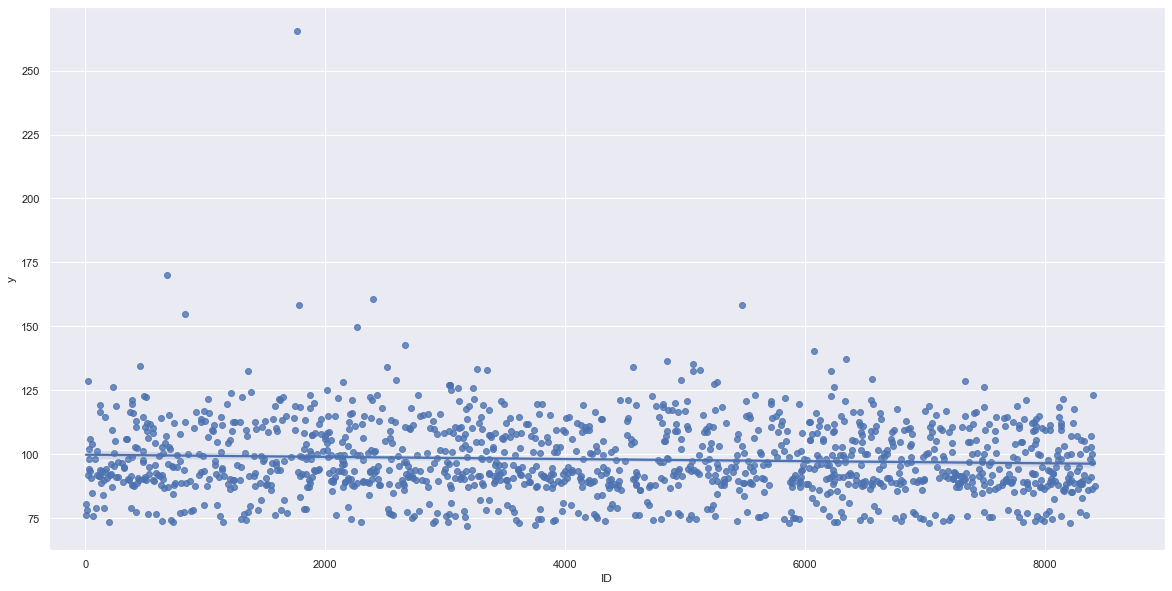

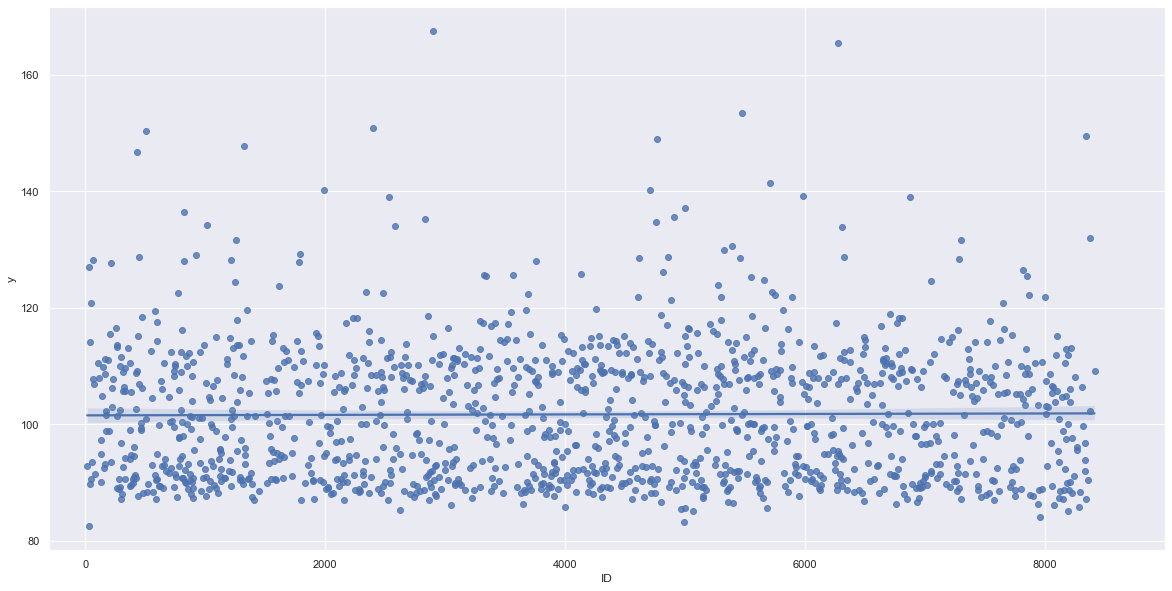

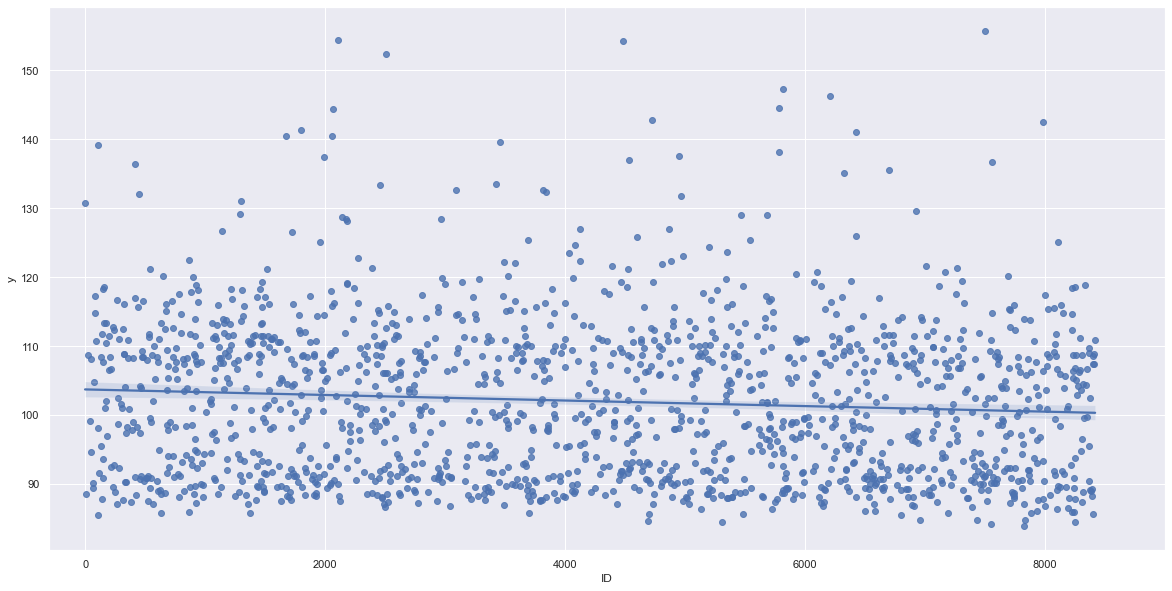

In [473]:
for x in label:
    plt.figure(figsize=(20,10))
    plt.xlim([-300,9000])
    sns.regplot(data=x, x='ID', y='y') #found outlier
plt.show()

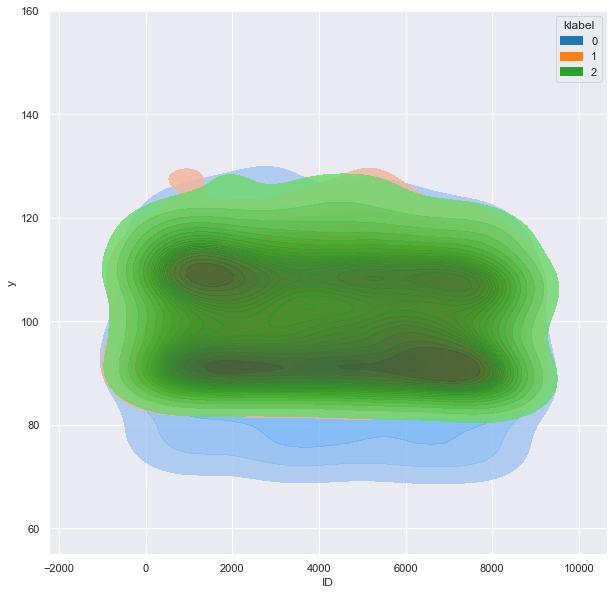

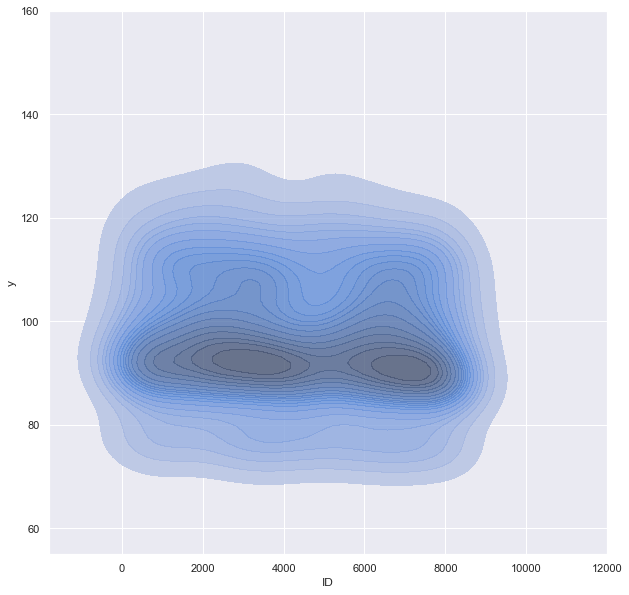

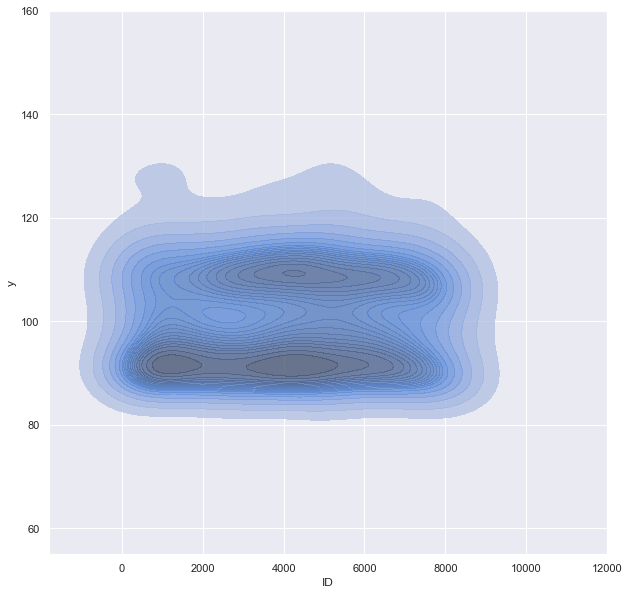

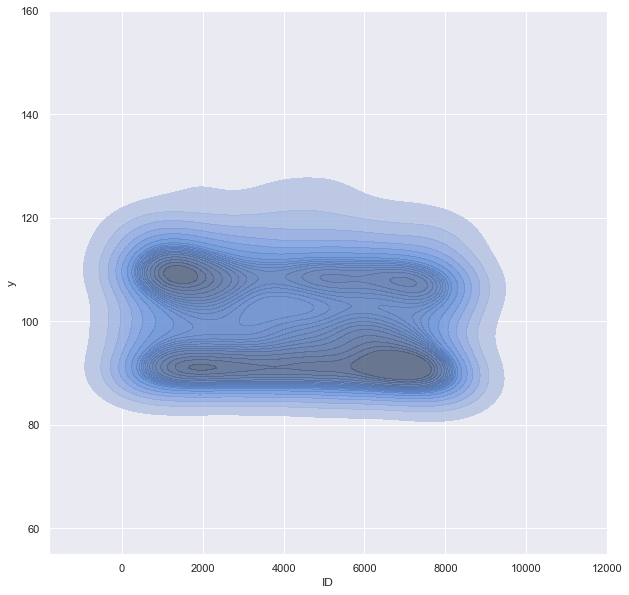

In [474]:
# colors = ['firebrick', 'steelblue', 'darkgreen', 'darkslategray'] #'darkslategray'

plt.figure(figsize=(10,10))
sns.kdeplot(data=pcascaleddf, x='ID', y='y', levels=20, fill=True, alpha=0.8, hue='klabel', palette='tab10')
plt.ylim([55,160])
plt.show()

for x in label:
    plt.figure(figsize=(10,10))
    sns.kdeplot(data=x, x='ID', y='y', levels=20, fill=True, alpha=0.8)
    plt.ylim([55,160])
    plt.xlim([-1800,12000])
    plt.show()

In [487]:
x1 = label[2].iloc[:,:-3]

In [488]:
y1 = label[2]['y']

In [493]:
x_train, x_valid, y_train, y_valid = train_test_split(x1, y1, test_size=0.2, random_state=4242)

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(test_1)

params = {}
params['objective'] = 'reg:squarederror'
params['eta'] = 0.03
params['max_depth'] = 3

def xgb_r2_score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

clf = xgb.train(params, d_train, 8000, watchlist, early_stopping_rounds=80, feval=xgb_r2_score, maximize=True, verbose_eval=10)

[0]	train-rmse:99.0981	valid-rmse:99.1869	train-r2:-74.6413	valid-r2:-73.1677
Multiple eval metrics have been passed: 'valid-r2' will be used for early stopping.

Will train until valid-r2 hasn't improved in 80 rounds.
[10]	train-rmse:73.4194	valid-rmse:73.5417	train-r2:-40.5193	valid-r2:-39.7731
[20]	train-rmse:54.5276	valid-rmse:54.7609	train-r2:-21.9013	valid-r2:-21.6072
[30]	train-rmse:40.6665	valid-rmse:40.9958	train-r2:-11.738	valid-r2:-11.6702
[40]	train-rmse:30.5313	valid-rmse:30.9462	train-r2:-6.17994	valid-r2:-6.21974
[50]	train-rmse:23.1777	valid-rmse:23.6765	train-r2:-3.13781	valid-r2:-3.22611
[60]	train-rmse:17.9003	valid-rmse:18.5227	train-r2:-1.46803	valid-r2:-1.58651
[70]	train-rmse:14.188	valid-rmse:14.9539	train-r2:-0.550492	valid-r2:-0.685833
[80]	train-rmse:11.629	valid-rmse:12.5361	train-r2:-0.041624	valid-r2:-0.184764
[90]	train-rmse:9.8974	valid-rmse:10.9371	train-r2:0.245479	valid-r2:0.098197
[100]	train-rmse:8.77118	valid-rmse:9.93944	train-r2:0.407423	valid-r2

[4748]	train-rmse:8.61115	valid-rmse:7.58087	train-r2:0.552294	valid-r2:0.591474

In [164]:
p_test = clf.predict(d_test)

In [162]:
p_test.shape

(1526,)

In [490]:
0.61276+0.41009+0.466508

1.489358

In [491]:
1.489358/3

0.49645266666666665

In [ ]:
0  = [179]	train-rmse:6.95478	valid-rmse:8.90455	train-r2:0.775448	valid-r2:0.61276
1  = [149]	train-rmse:7.73443	valid-rmse:8.71594	train-r2:0.559929	valid-r2:0.41009
2  = [200]	train-rmse:6.57954	valid-rmse:8.41222	train-r2:0.666559	valid-r2:0.466508